In [1]:
library(tidyverse)
library(dplyr)
library(repr)
library(tidymodels)
library(recipes)
install.packages("themis")
library(themis)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

## Introduction

- Wine quality highly depends on its composition of various aromatic compounds. By assessing the content of wines such as their sugar content and pH value, we will be able to determine how good the wine is. 
- In this project, we will be using the wine quality dataset obtained from a web URL.
- We want to solve **regression problem** —- what would be the wine’s quality level given its values on the fixed acidity, volatile acidity, and other variables.
-  7 out of the 12 variables are used to predict the **wine quality**, which ranges from 0 to 10, with 10 being the highest quality wine.
- We focus on indicating which attributes affect the wine quality and predicting the quality based on each attribute's values. By using the regression method, we create a linear formula and use the coefficients to know how the attribute level influences the wine quality(i.e. it positively/negatively influences the wine quality).

## Preliminary exploratory data analysis

**1. Data Reading**

In [2]:
temp <- tempfile()
download_file <- download.file("https://archive.ics.uci.edu/static/public/186/wine+quality.zip", temp)
red_wine <- read.csv2(unz(temp, "winequality-red.csv")) |>
             mutate(type = "Red")
white_wine <- read.csv2(unz(temp, "winequality-white.csv")) |>
              mutate(type ="White")
head(red_wine)
head(white_wine)
unlink(temp)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,Red
2,7.8,0.88,0,2.6,0.098,25,67,0.9968,3.2,0.68,9.8,5,Red
3,7.8,0.76,0.04,2.3,0.092,15,54,0.997,3.26,0.65,9.8,5,Red
4,11.2,0.28,0.56,1.9,0.075,17,60,0.998,3.16,0.58,9.8,6,Red
5,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,Red
6,7.4,0.66,0,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,Red


,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8,6,White
2,6.3,0.3,0.34,1.6,0.049,14,132,0.994,3.3,0.49,9.5,6,White
3,8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6,White
4,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6,White
5,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6,White
6,8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6,White


**2. Data Wrangling**

In [3]:
wine_data <- rbind(red_wine, white_wine) |>
             mutate(across(fixed.acidity:alcohol, as.numeric), quality = as.numeric(quality),
                   type = as_factor(type))
write_csv(wine_data, "../data/wine_data.csv")
head(wine_data)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,Red
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,Red
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,Red
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,Red
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,Red
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,Red


**3. Data Splitting**

To know how good our prediction is, we should split our data into training dataset and testing dataset.

In [4]:
set.seed(2000)
wine_split <- initial_split(wine_data, prop = 0.75, strata = quality)
wine_training <- training(wine_split)
wine_testing <- testing(wine_split)

**4. Summarization**

**a. The number of observations in each red wine/white wine class**

In [5]:
wine_type_number <- wine_training |>
                    group_by(type) |>
                    summarize(Number = n())
wine_type_number

type,Number
<fct>,<int>
Red,1220
White,3652


- We have 4898 observations for White wine and 1599 observations for Red wine.
- There is an imbalance between the types of the wine. 

**b. The number of observations for each quality level.**

In [6]:
quality_number <- wine_training |>
                  group_by(quality) |>
                  summarize(Number = n())
quality_number

quality,Number
<dbl>,<int>
3,26
4,162
5,1600
6,2127
7,810
8,143
9,4


- We are missing two classes: 0, 1, 2 and 10.
- This is another class imbalance existed within the class

**c. Mean value of each measurements for different quality type.**

In [7]:
mean_measurements <- wine_training |>
                     group_by(quality) |>
                     summarize(mean_fixed_acidity = mean(fixed.acidity),
                               mean_volatile_acidity = mean(volatile.acidity),
                               mean_citric_acid = mean(citric.acid),
                               mean_residual_sugar = mean(residual.sugar),
                               mean_chlorides = mean(chlorides),
                               mean_free_sufdioxide = mean(free.sulfur.dioxide),
                               mean_tot_sufdioxide = mean(total.sulfur.dioxide),
                               mean_density = mean(density),
                               mean_ph = mean(pH),
                               mean_sulphates = mean(sulphates),
                               mean_alcohol = mean(alcohol))
mean_measurements

quality,mean_fixed_acidity,mean_volatile_acidity,mean_citric_acid,mean_residual_sugar,mean_chlorides,mean_free_sufdioxide,mean_tot_sufdioxide,mean_density,mean_ph,mean_sulphates,mean_alcohol
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,7.807692,0.5182692,0.2715385,4.623077,0.07911538,42.51923,129.6923,0.9954881,3.253846,0.5069231,10.201923
4,7.323457,0.4564815,0.2803704,4.264198,0.06016049,21.56790,105.3241,0.9949722,3.227284,0.5123457,10.158642
5,7.335750,0.3938531,0.3059750,5.805750,0.06529562,30.25156,120.7506,0.9958872,3.209694,0.5275750,9.829279
6,7.190574,0.3153220,0.3236624,5.550987,0.05421909,31.05125,115.0835,0.9945737,3.216878,0.5338834,10.587980
7,7.067284,0.2898704,0.3308889,4.644198,0.04461975,30.52963,108.4975,0.9930078,3.229975,0.5450864,11.395144
8,6.905594,0.2984965,0.3374825,5.098601,0.04057343,35.45455,116.3077,0.9924151,3.218531,0.5192308,11.746154
9,7.000000,0.3050000,0.3700000,2.500000,0.02550000,34.75000,114.0000,0.9900750,3.335000,0.4675000,12.625000


The ranges of the mean are different across different columns hence the variables will need to be scaled 

**d. Missing data - We have no missing data in this dataset.**

**4. Visualization: histogram between quality and other numeric variables**

Warning message:
“The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message:
“The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


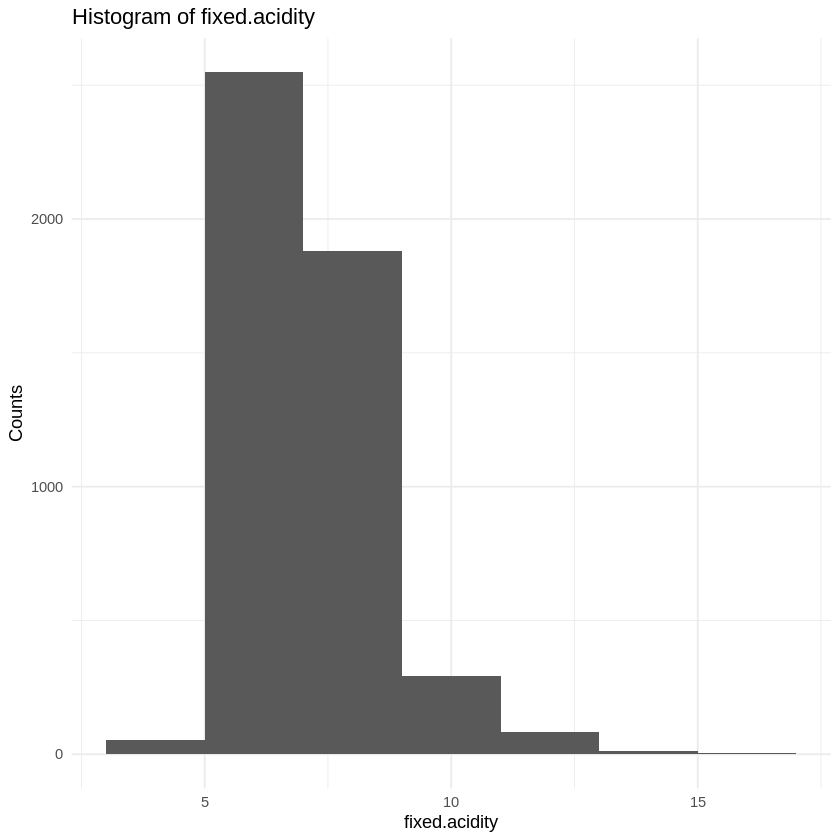

Warning message:
“The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


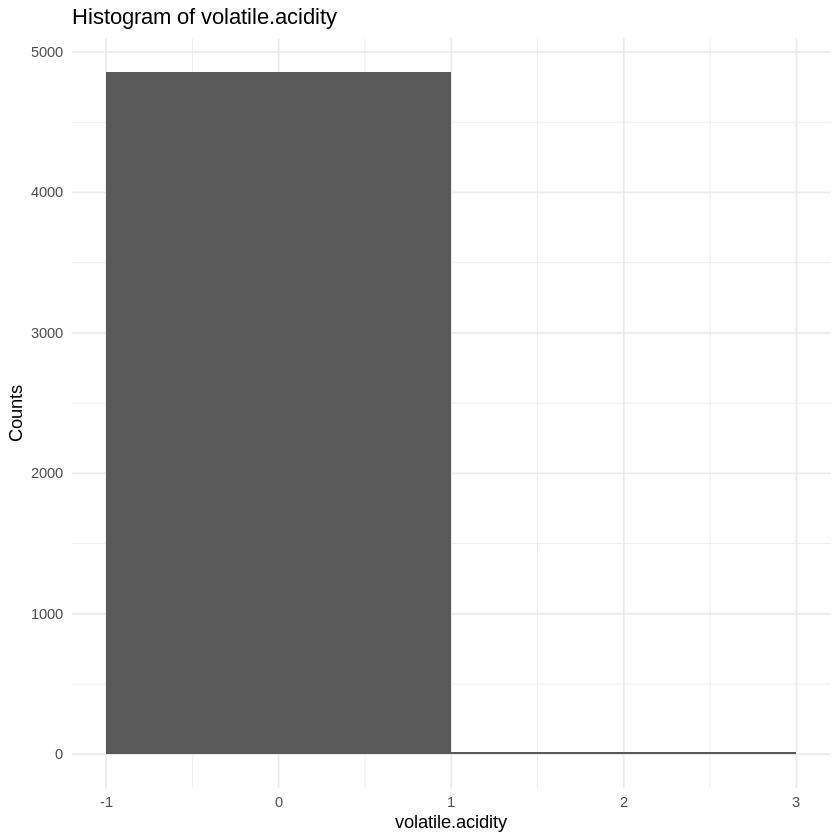

Warning message:
“The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


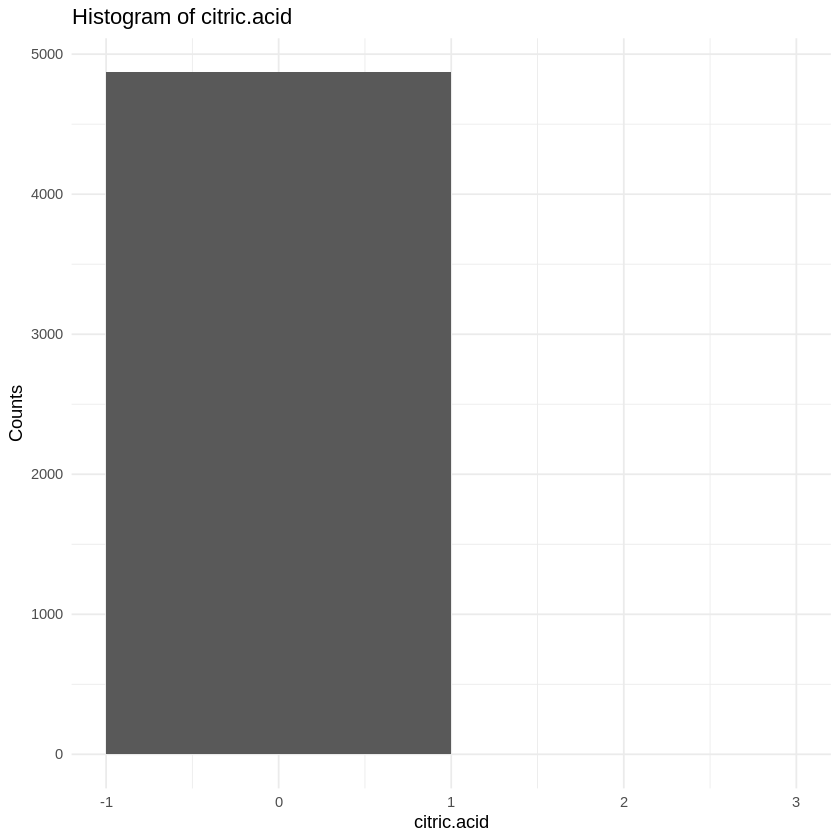

Warning message:
“The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


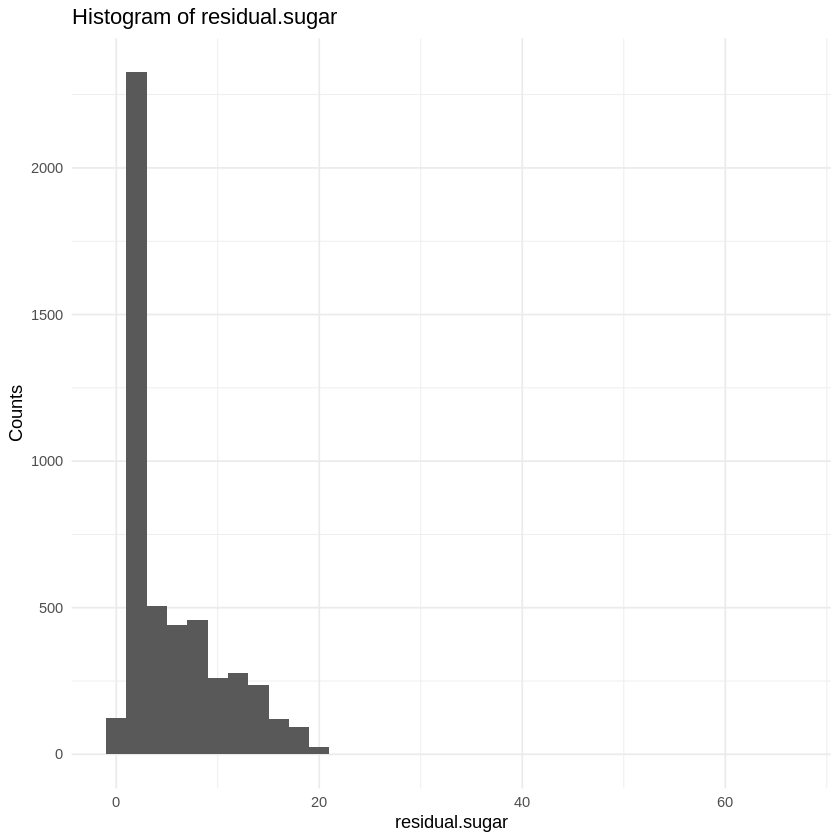

Warning message:
“The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


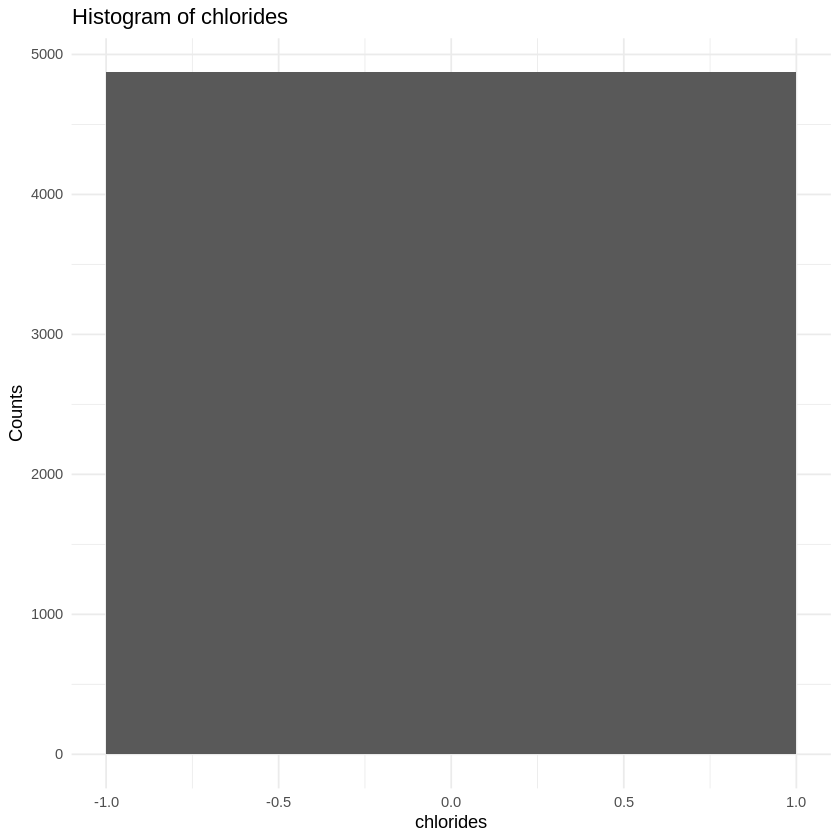

Warning message:
“The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


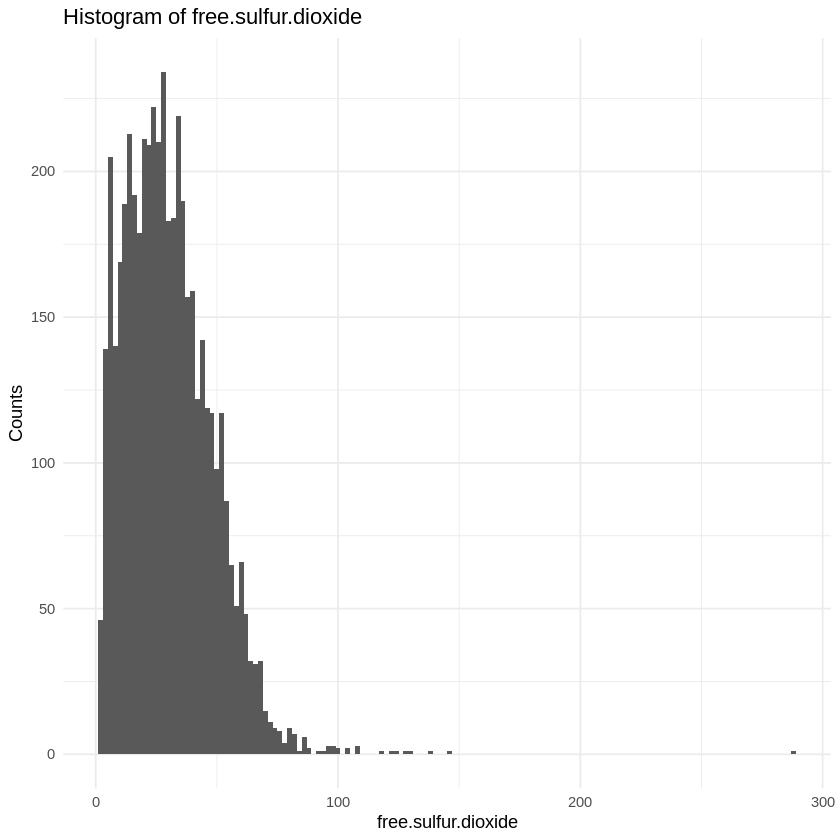

Warning message:
“The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


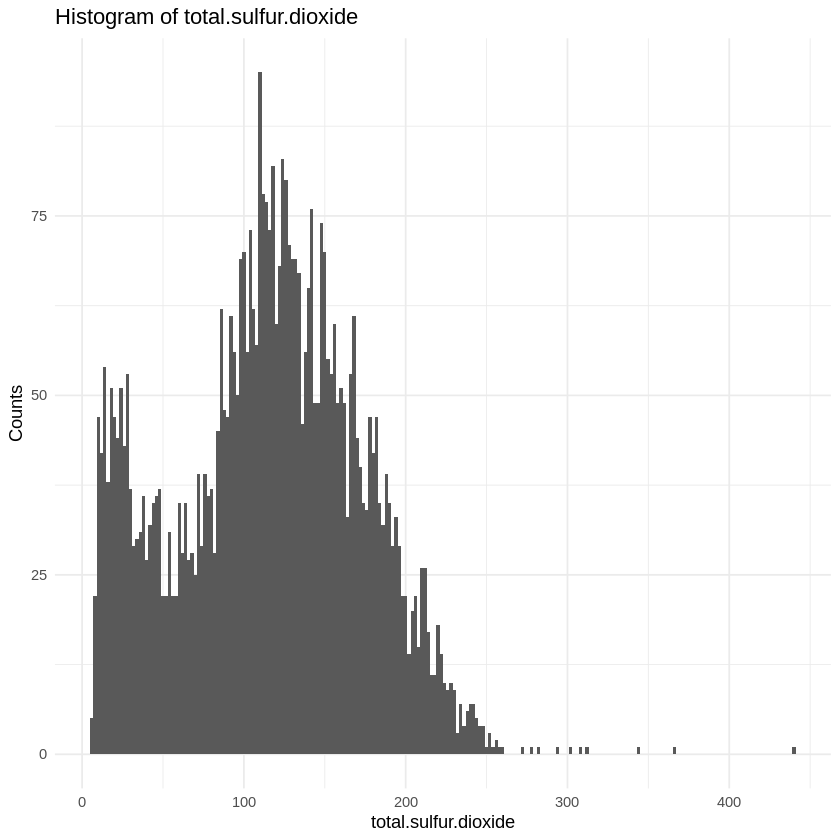

Warning message:
“The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


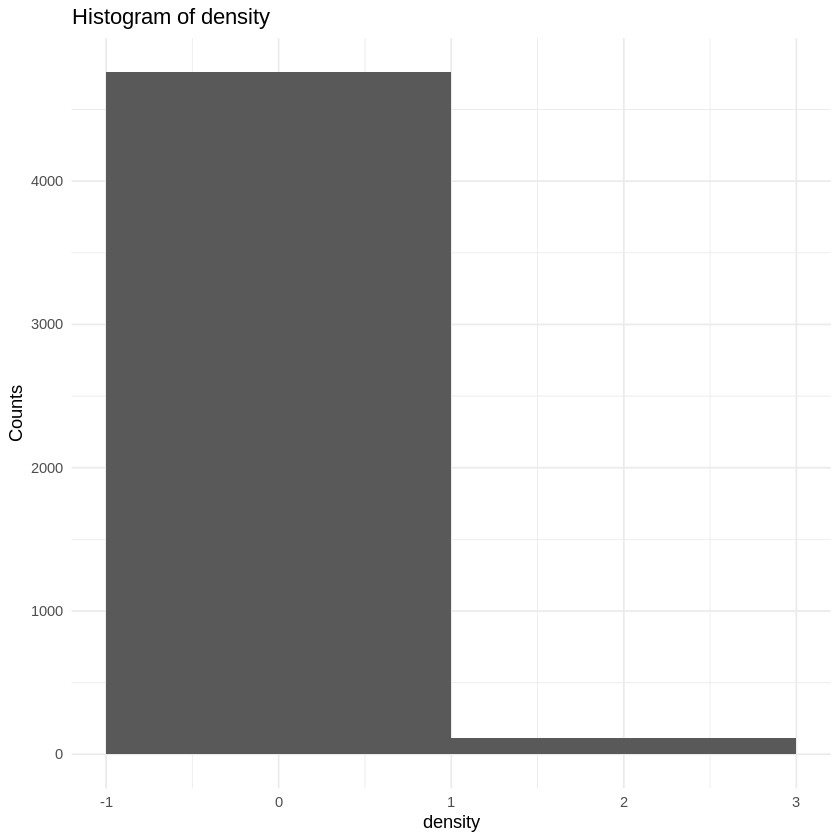

Warning message:
“The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


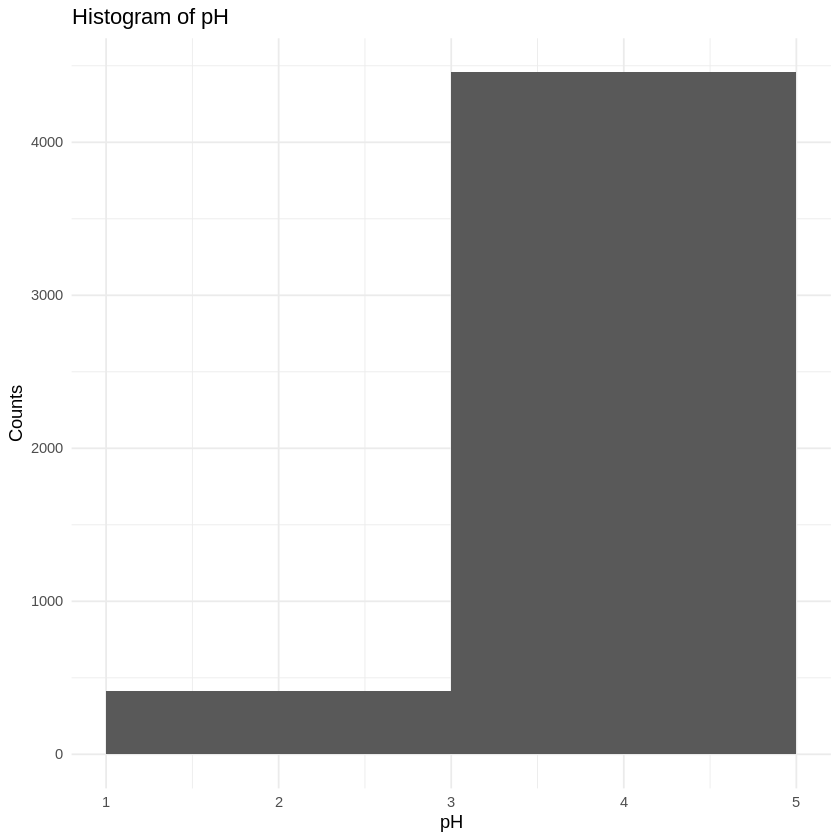

Warning message:
“The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]


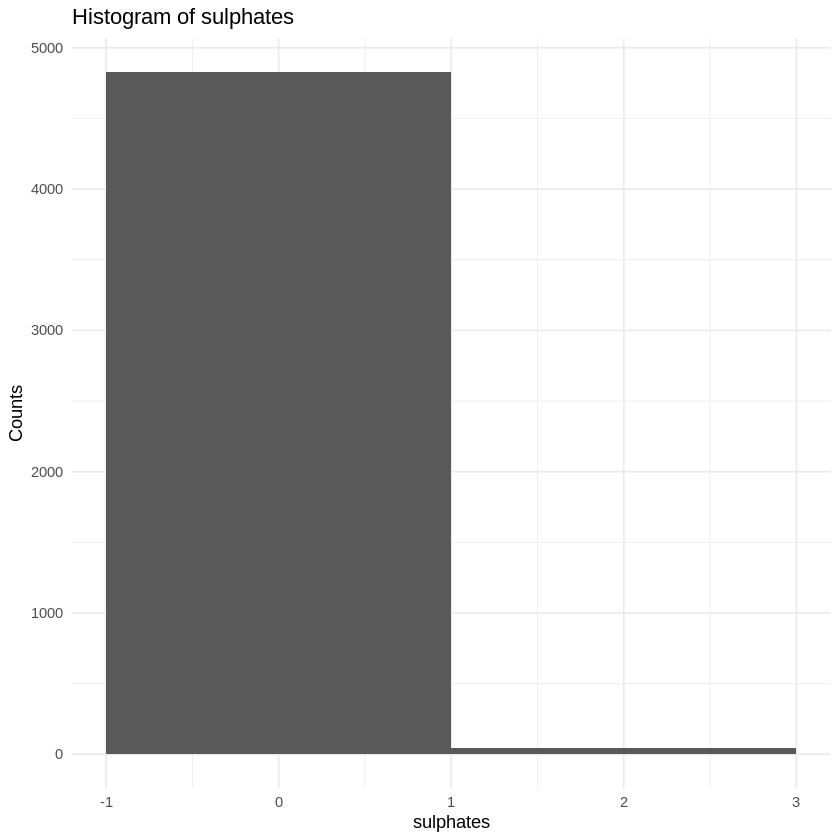

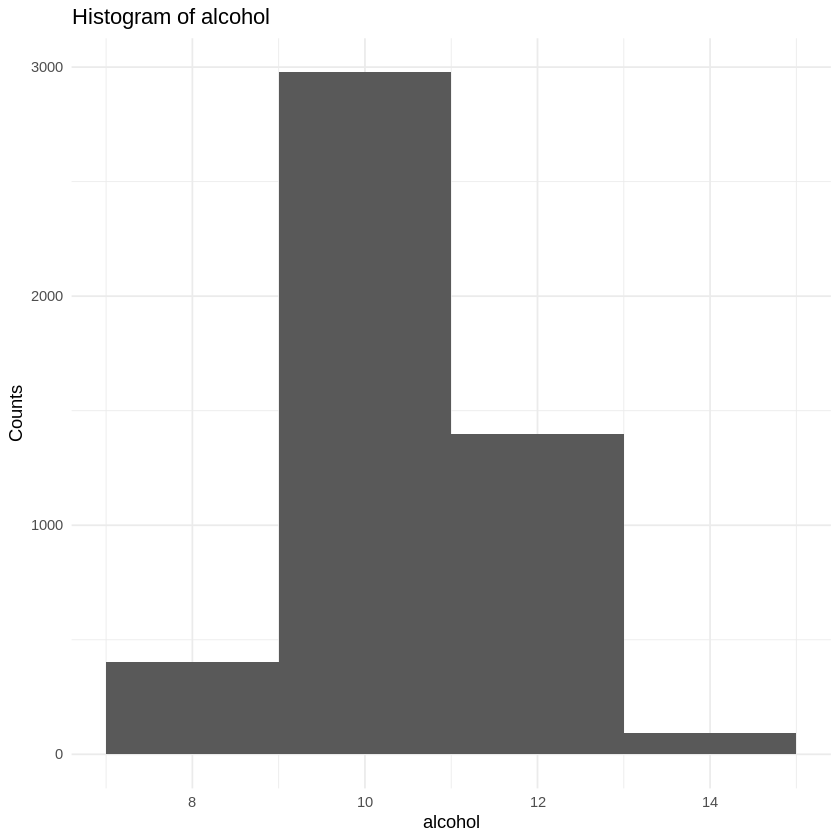

In [8]:
wine_filter <- wine_training |>
               select(-type)

histograms <- lapply(names(wine_filter)[!names(wine_filter) %in% c("quality")], function(col) {
  ggplot(wine_filter, aes(x = !!sym(col), fill = quality)) +
    geom_histogram(position = "dodge", bins = 100, binwidth = 2) +
    labs(title = paste("Histogram of", col), x = col, y = "Counts", fill = "Quality") +
    theme_minimal()
})

histograms

- Most variables have a linear negative correlation to quality
- free.sulfur.dioxide and total.sulfur. dioxide seems to have no correlation with quality as the categories' bins are layered in the histogram.
- alcohol and residual.sugar have a non-linear relationship with quality

## Training & Evaluation

### 1. The multivariable Linear regression Model

In [9]:
set.seed(1)
wine_data_reg <- wine_data |>
    mutate(quality = as.numeric(quality)) |>
    select(fixed.acidity, volatile.acidity, citric.acid, chlorides, density, pH, sulphates, quality)
head(wine_data_reg)

,fixed.acidity,volatile.acidity,citric.acid,chlorides,density,pH,sulphates,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7.4,0.70,0.00,0.076,0.9978,3.51,0.56,5
2,7.8,0.88,0.00,0.098,0.9968,3.20,0.68,5
3,7.8,0.76,0.04,0.092,0.9970,3.26,0.65,5
4,11.2,0.28,0.56,0.075,0.9980,3.16,0.58,6
5,7.4,0.70,0.00,0.076,0.9978,3.51,0.56,5
6,7.4,0.66,0.00,0.075,0.9978,3.51,0.56,5


In [10]:
wine_reg_split <- initial_split(wine_data_reg, prop = 0.75, strata = quality)
wine_reg_training <- training(wine_reg_split)
wine_reg_testing <- testing(wine_reg_split)

In [11]:
lm_recipe <- recipe(quality ~ .,
                    data = wine_reg_training)
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

lm_fit <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = wine_reg_training)

lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
     (Intercept)     fixed.acidity  volatile.acidity       citric.acid  
        98.18981           0.07081          -1.20272           0.11662  
       chlorides           density                pH         sulphates  
        -2.54842         -94.87789           0.47164           0.92052  


In [12]:
lm_test_results <- lm_fit |>
  predict(wine_reg_testing) |>
  bind_cols(wine_reg_testing) |>
  metrics(truth = quality, estimate = .pred)

lm_test_results

lm_coeffs <- lm_fit |>
             extract_fit_parsnip() |>
             tidy()
lm_coeffs

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.7961641
rsq,standard,0.1368839
mae,standard,0.6276042


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),98.18981496,4.51163265,21.763699,2.720687e-100
fixed.acidity,0.07081299,0.01166027,6.073014,1.350782e-09
volatile.acidity,-1.20271824,0.08963815,-13.417481,2.472252e-40
citric.acid,0.11661846,0.09635233,1.210334,2.262097e-01
chlorides,-2.54841714,0.39146268,-6.509987,8.273613e-11
density,-94.87789342,4.58459125,-20.694951,2.966185e-91
pH,0.47163719,0.08120095,5.808272,6.713438e-09
sulphates,0.92051828,0.08756170,10.512796,1.415645e-25


The RMSPE of this linear regression model is 0.7961641

The mathematical expression to describe this linear regression model is:
$quality = 3.81887647 + 0.09180436 \cdot (fixed.acidity) - 0.19801129 \cdot (volatile.acidity) + 0.01694675 \cdot (citric.acid) - 0.08928023 \cdot (chlorides) - 0.08928023 \cdot (density) + 0.07583322 \cdot (pH) + 0.13697853 \cdot (sulphates)$

### 2. K-nn regression Model

In [13]:
knn_recipe <- recipe(quality ~ ., data = wine_reg_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

In [14]:
wine_knnreg_spec <- nearest_neighbor(weight_func = "rectangular",
                                     neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

In [15]:
knn_vfold <- vfold_cv(wine_training, v = 5, strata = quality)

knn_workflow <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(wine_knnreg_spec)
knn_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [16]:
gridvals <- tibble(neighbors = seq(1, 200))

knn_reg_results <- knn_workflow |>
  tune_grid(resamples = knn_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

# show the results
head(knn_reg_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,0.8696112,5,0.013407698,Preprocessor1_Model001
2,rmse,standard,0.8015102,5,0.008901973,Preprocessor1_Model002
3,rmse,standard,0.7786217,5,0.008283398,Preprocessor1_Model003
4,rmse,standard,0.7690428,5,0.007069132,Preprocessor1_Model004
5,rmse,standard,0.7642273,5,0.006449984,Preprocessor1_Model005
6,rmse,standard,0.7592774,5,0.006180466,Preprocessor1_Model006


In [17]:
knn_min <- knn_reg_results |>
    filter(mean == min(mean))
knn_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
12,rmse,standard,0.7483945,5,0.004529225,Preprocessor1_Model012


The smallest RMSPE occurs when K = 19.

In [18]:
kmin <- knn_min |> pull(neighbors)

knn_reg_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

knn_reg_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_reg_spec) |>
  fit(data = wine_reg_training)

knn_reg_summary <- knn_reg_fit |>
  predict(wine_reg_testing) |>
  bind_cols(wine_reg_testing) |>
  metrics(truth = quality, estimate = .pred) |>
  filter(.metric == 'rmse')

knn_reg_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.7325462


### 2. Classification Model

In [19]:
wine_data_class <- wine_data |>
    select(fixed.acidity, volatile.acidity, citric.acid, chlorides, density, pH, sulphates, quality)

wine_data_class$quality <- as.factor(wine_data_class$quality)

Before doing the classification model, we need to centering, scaling, and balance the data first.

In [21]:
set.seed(1)
wine_class_split <- initial_split(wine_data_class, prop = 0.75, strata = quality)
wine_class_training <- training(wine_class_split)
wine_class_testing <- testing(wine_class_split)
# We do the centering and scaling here
knn_recipe <- recipe(quality ~ ., data = wine_class_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()

wine_scaled_class <- bake(knn_recipe, wine_data_class)
head(wine_scaled_class)

#Then we do the upsampling
knn_recipe <- knn_recipe |>
 step_upsample(quality, over_ratio = 1, skip = FALSE) |>
  prep()
knn_recipe

upsampled_wine_class <- bake(knn_recipe, wine_data_class)
# We check the upsampling result here
upsampled_wine_result |>
  group_by(quality) |>
  summarize(n = n())
upsampled_wine_result

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_workflow <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec)

knn_res <- tune_grid(
    knn_workflow,
    resamples = vfold_cv(wine_class_training, v = 5),
    grid = data.frame(neighbors = seq(1, 50, 5))
)

best_k <- knn_res |>
    select_best("accuracy")

knn_final <- finalize_workflow(knn_workflow, best_k)

knn_fit <- fit(knn_final, data = wine_class_training)

knn_pred <- predict(knn_fit, new_data = wine_class_testing) |>
    bind_cols(wine_class_testing)

accuracy(knn_pred, truth = quality, estimate = .pred_class)

knn_pred_num <- knn_pred |>
    mutate(quality_num = as.numeric(quality),
            .pred_class_num = as.numeric(.pred_class))

knn_rmse <- rmse(knn_pred_num, truth = quality_num, estimate = .pred_class_num)

knn_rmse

fixed.acidity,volatile.acidity,citric.acid,chlorides,density,pH,sulphates,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.1254895,2.1622785,-2.211396,0.5571445,1.0186642,1.8091027,0.2003058,5
0.4311575,3.2441457,-2.211396,1.1734895,0.6876365,-0.1074265,1.0112965,5
0.4311575,2.5229009,-1.934689,1.0053954,0.7538420,0.2635147,0.8085488,5
3.0293354,-0.3620784,1.662499,0.5291289,1.0848697,-0.3547205,0.3354709,6
0.1254895,2.1622785,-2.211396,0.5571445,1.0186642,1.8091027,0.2003058,5
0.1254895,1.9218635,-2.211396,0.5291289,1.0186642,1.8091027,0.2003058,5




── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 7



── Training information 

Training data contained 4871 data points and no incomplete rows.



── Operations 

• Scaling for: fixed.acidity, volatile.acidity, citric.acid, ... | Trained

• Centering for: fixed.acidity, volatile.acidity, citric.acid, ... | Trained

• Up-sampling based on: quality | Trained



ERROR: Error in eval(expr, envir, enclos): object 'upsampled_wine_result' not found


The accuracy observed in this classification model is 0.603936, and the RMSE in this classificaiton model is 0.849354

## Methods

- After data reading and wrangling, we used all 12 variables for preliminary data summarization and visualization. We then compared the number of observations in each red/ white wine class, the number of observations in each quality level for red and white wine respectively, and the mean value of each feature for each quality level. 

- Multi-histogram is used to visualize the relationship between each variable and the wine quality, each with one predictor on the x axis, counts on the y axis, and color indicating the different quality levels. If each quality level tends to show up on a certain value of the x axis, we can conclude that there is linear correlation between the wine quality and that predictor. Otherwise, there is no correlation or non-linear correlation. 

- **We will only use 7 numeric variables excluding type total.sulfur.dioxide, free.sulfur.dioxide, residual sugar and alcohol** 

## Expected outcomes and significance

- Due to class imbalance in the categories of the target column (quality): some of the categories are missing. We expect the model will be less precise for the level from 0 to 2 and the level 10.
- However, we hope the model will be able to predict correctly the quality from 3 - 8

- These findings will allow a more efficient and more systematic wine quality assessment as we will be able assess the quality of the wines not only by its age or individual tastes, but also the actual content in the wine itself.
-  The findings can also lead to further discoveries such as how different environments in which the grapes grew in would affect the quality of the wines, in which they can be used to optimize the wine development.
